In [1]:
import re
import pandas as pd
from functools import reduce
from tqdm.notebook import tqdm
from pyscripts.config import path2
from pyscripts.datasets import DatasetLoader
from pyscripts.genomeutil import iter_cds_nonoverlapping_regions, get_intervaltree
dloader = DatasetLoader()


In [2]:
str5_refs = pd.read_csv(path2.metadata/'expression'/'Kim+20SciData_refs.tsv', sep='\t')
str5_runs = pd.read_csv(path2.metadata/'expression'/'Kim+20SciData_runs.tsv', sep='\t')

In [3]:
str5_workdir = path2.data/'expression'/'Kim+20SciData'
      
def read_plus_depth(tag):
    return tag, pd.read_pickle(str5_workdir/'depth'/f'{tag}.plus.pkl.bz2')

def read_minus_depth(tag):
    return tag, pd.read_pickle(str5_workdir/'depth'/f'{tag}.minus.pkl.bz2')

from multiprocessing import Pool
with Pool(80) as pool:
    str5_plus  = dict(tqdm(pool.imap_unordered(read_plus_depth , str5_runs['tag']), total=80))
    str5_minus = dict(tqdm(pool.imap_unordered(read_minus_depth, str5_runs['tag']), total=80))


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

In [4]:
str5_plus_norm, str5_minus_norm = {}, {}

for (sp, acc), run_sp in str5_runs.groupby(['species_code', 'reference_assembly']):
    rec = max(dloader.load_genome(acc, dirname=path2.pubdata/'expression'/'Kim+20SciData'/'reference'), key=len)
    plus_idx = sorted([
        i
        for loc_tag, loc in iter_cds_nonoverlapping_regions(rec)
        if loc.strand > 0
        for pt in loc.parts for i in range(pt.start, pt.end)
    ])
    minus_idx = sorted([
        i
        for loc_tag, loc in iter_cds_nonoverlapping_regions(rec)
        if loc.strand < 0
        for pt in loc.parts for i in range(pt.start, pt.end)
    ])

    for ty, run_spty in run_sp.groupby('type'):
        print(sp, ty)
        tmp_plus, tmp_minus = {}, {}
        
        for tag in run_spty['tag']:
            plus  = str5_plus[tag][rec.id]
            minus = str5_minus[tag][rec.id]
            
            if ty == 'Ribo':
                if rec.annotations['topology'] == 'linear':
                    plus  = sum(plus.shift(-p, fill_value=0) for p in range(28))
                    minus = sum(minus.shift(p, fill_value=0) for p in range(28))
                else:
                    plus  = sum(np.roll(plus, -p) for p in range(28))
                    minus = sum(np.roll(minus, p) for p in range(28))
                    
            thresh = (plus[plus_idx].mean() + minus[minus_idx].mean()) / 2
            tmp_plus[tag]  = plus  / thresh
            tmp_minus[tag] = minus / thresh

        str5_plus_norm[(sp,ty)]  = pd.DataFrame(tmp_plus)
        str5_minus_norm[(sp,ty)] = pd.DataFrame(tmp_minus)


Save RNA
Save Ribo
Scla RNA
Scla Ribo
Sliv RNA
Sliv Ribo
Stsu RNA
Stsu Ribo
Sven RNA
Sven Ribo


In [5]:
OGs = pd.read_csv(
    '../../data/expression/Kim+20SciData/noncoding_og/output/runs/default/ortholog_groups/flat.ortholog_groups.tsv', 
    sep='\t', index_col=0
)

In [6]:
conservedOGs = OGs[(OGs != '*').all(axis=1)]

In [7]:
ptrn = re.compile('(?P<recid>.+)\[(?P<start>\d+):(?P<end>\d+)\]\((?P<strand>[+-])\)')
def assign(*args): return True

def find_rna_signal(idx_og):
    idx, og = idx_og
    sig = {
        sp: max([
            norm[(sp, 'RNA')][start:end].mean().max()
            for name in names.split(',')
            if assign(
                m := re.fullmatch(ptrn, name),
                start  := int(m.group('start')), 
                end    := int(m.group('end')), 
                strand := m.group('strand'),
                norm   := (str5_plus_norm if strand == '+' else str5_minus_norm)
            )
        ])
        for sp, names in og.items()
    }
    return idx, sig

def find_ribo_signal(idx_og):
    idx, og = idx_og
    sig = {
        sp: max([
            norm[(sp, 'Ribo')][start:end].mean().max()
            for name in names.split(',')
            if assign(
                m := re.fullmatch(ptrn, name), 
                start  := int(m.group('start')), 
                end    := int(m.group('end')), 
                strand := m.group('strand'),
                norm   := (str5_plus_norm if strand=='+' else str5_minus_norm)
            )
        ])
        for sp, names in og.items()
    }
    return idx, sig

from multiprocessing import Pool
with Pool(10) as pool:
    rna_signals = pd.DataFrame(dict(tqdm(pool.imap_unordered(find_rna_signal, conservedOGs.to_dict(orient='index').items()))))
    ribo_signals = pd.DataFrame(dict(tqdm(pool.imap_unordered(find_ribo_signal, conservedOGs.to_dict(orient='index').items()))))
    

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [8]:
expression_signals = pd.concat([
    rna_signals.loc[:,((rna_signals >= 0.1) & (ribo_signals >= 0.1)).all()],
    ribo_signals.loc[:,((rna_signals >= 0.1) & (ribo_signals >= 0.1)).all()]
], keys=['RNA', 'Ribo'])


In [9]:
is_single = (conservedOGs.applymap(lambda s: len(s.split(','))) == 1).all(axis=1)

In [10]:
import matplotlib.pyplot as plt

In [11]:
itvs = {}
for ref, sp in zip(str5_refs['reference_assembly'], str5_refs['species_code']):
    rec = max(dloader.load_genome(ref, dirname=path2.pubdata/'expression'/'Kim+20SciData'/'reference'), key=len)
    itvs[sp] = get_intervaltree(rec, filt_func=lambda f: f.type in {'CDS', 'tRNA', 'rRNA'})

In [38]:
nmap = {
    'Save': 'S. avermitilis',
    'Scla': 'S. clavuligerus',
    'Sven': 'S. venezuelae',
    'Stsu': 'S. tsukubensis',
    'Sliv': 'S. lividans'
}

Save NC_003155.5[4997823:4998021](+)
Scla NZ_CP027858.1[3031639:3031837](+)
Sliv NZ_CP009124.1[3935068:3935266](+)
Stsu NZ_CP020700.1[3642202:3642400](+)
Sven CP013129.1[4789017:4789215](-)

Save NC_003155.5[4997851:4997986](+)
Scla NZ_CP027858.1[3031667:3031802](+)
Sliv NZ_CP009124.1[3935096:3935231](+)
Stsu NZ_CP020700.1[3642242:3642347](+)
Sven CP013129.1[4789052:4789187](-)

Save NC_003155.5[5779938:5780706](-)
Scla NZ_CP027858.1[3979078:3980020](-)
Sliv NZ_CP009124.1[4685791:4686769](-)
Stsu NZ_CP020700.1[4658094:4659039](-)
Sven CP013129.1[3987718:3988135](+)

Save NC_003155.5[5884531:5884633](-)
Scla NZ_CP027858.1[2595995:2596127](+)
Sliv NZ_CP009124.1[3488746:3488848](+)
Stsu NZ_CP020700.1[4760483:4760585](-)
Sven CP013129.1[5195619:5195721](-)

Save NC_003155.5[5942251:5942674](-)
Scla NZ_CP027858.1[2551265:2551688](+)
Sliv NZ_CP009124.1[3442360:3442777](+)
Stsu NZ_CP020700.1[4805335:4805758](-)
Sven CP013129.1[5247955:5248384](-)



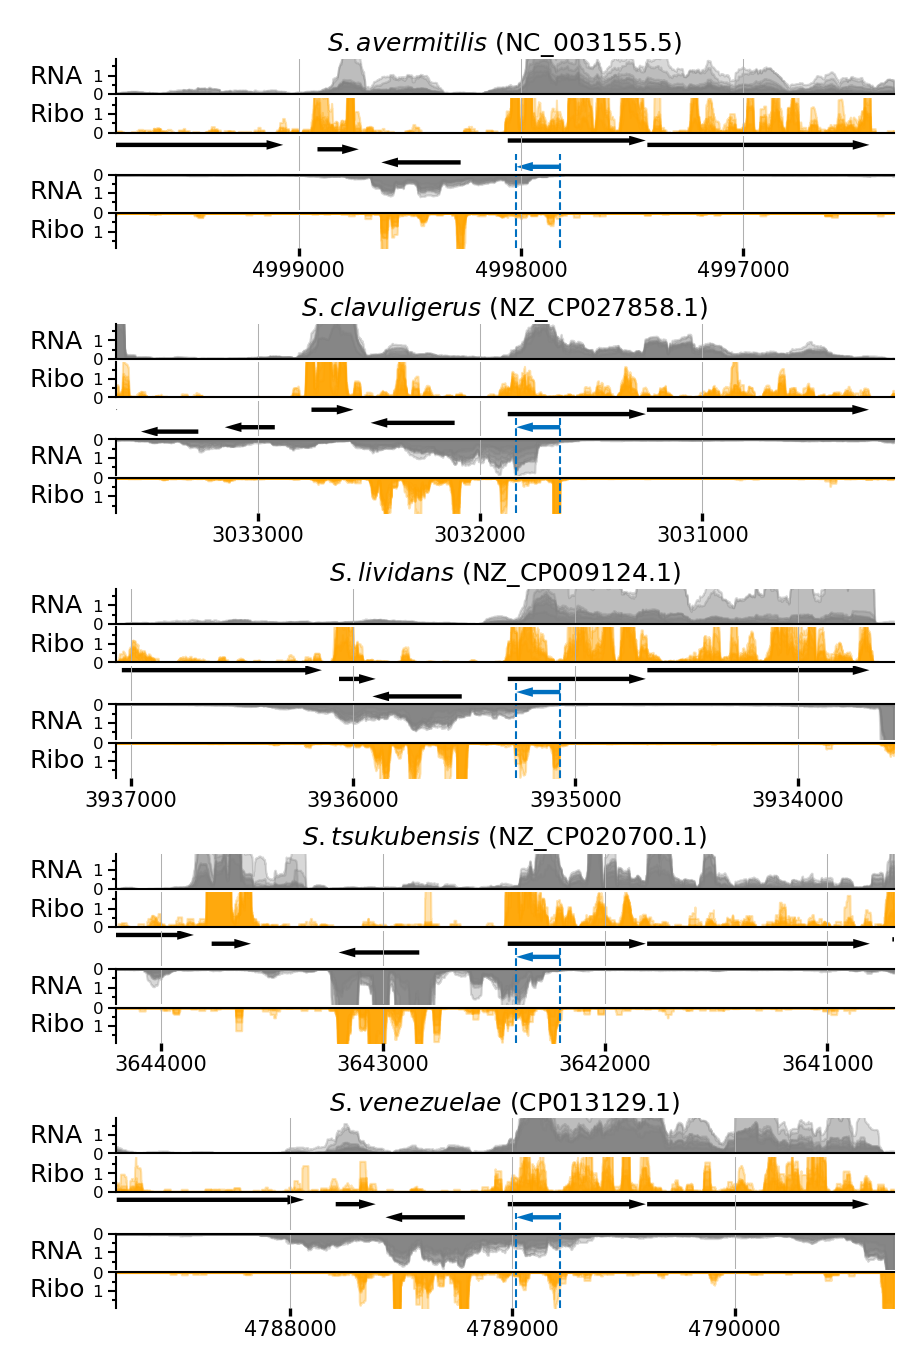

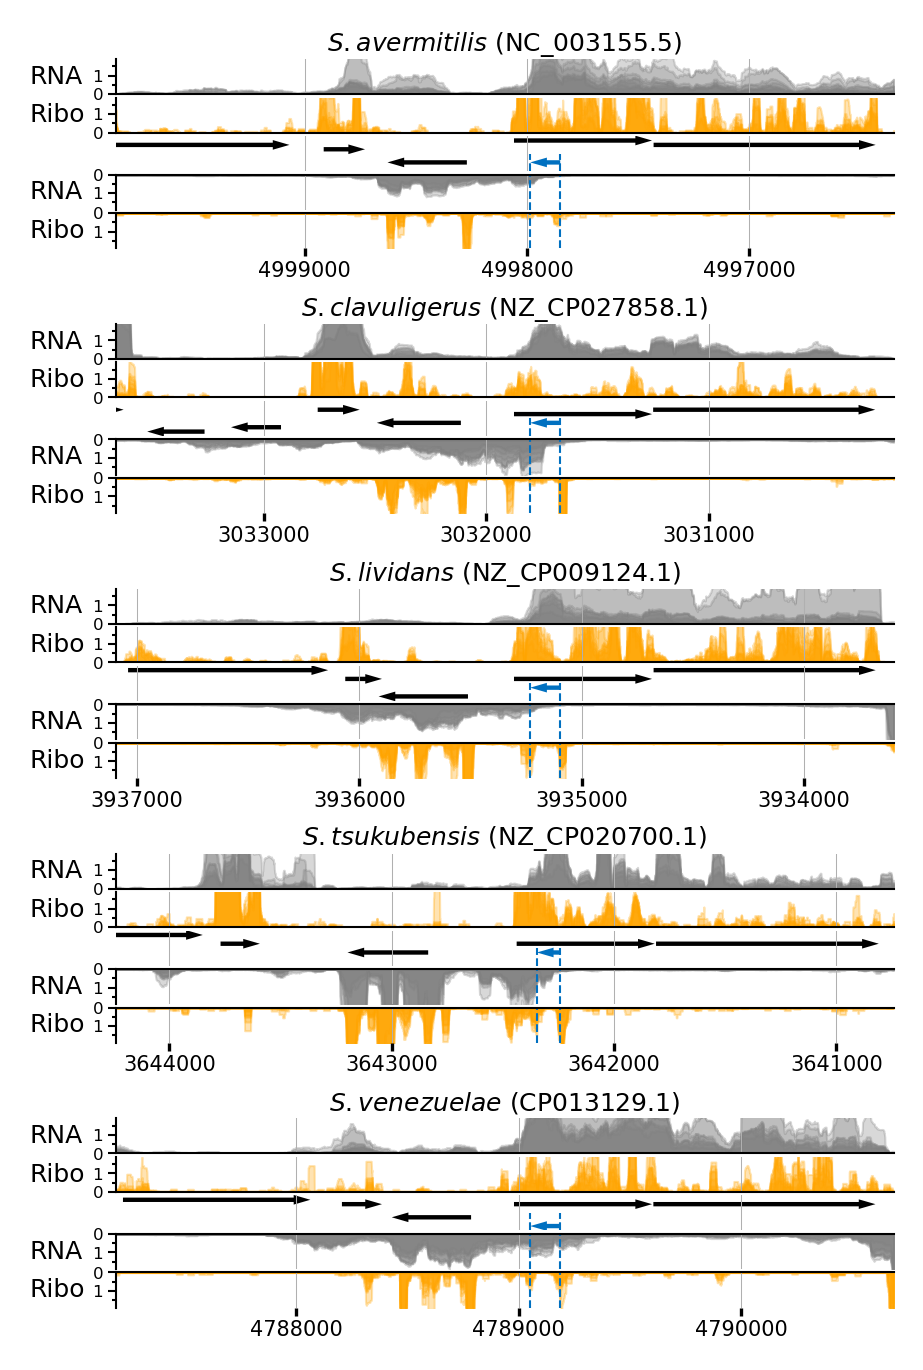

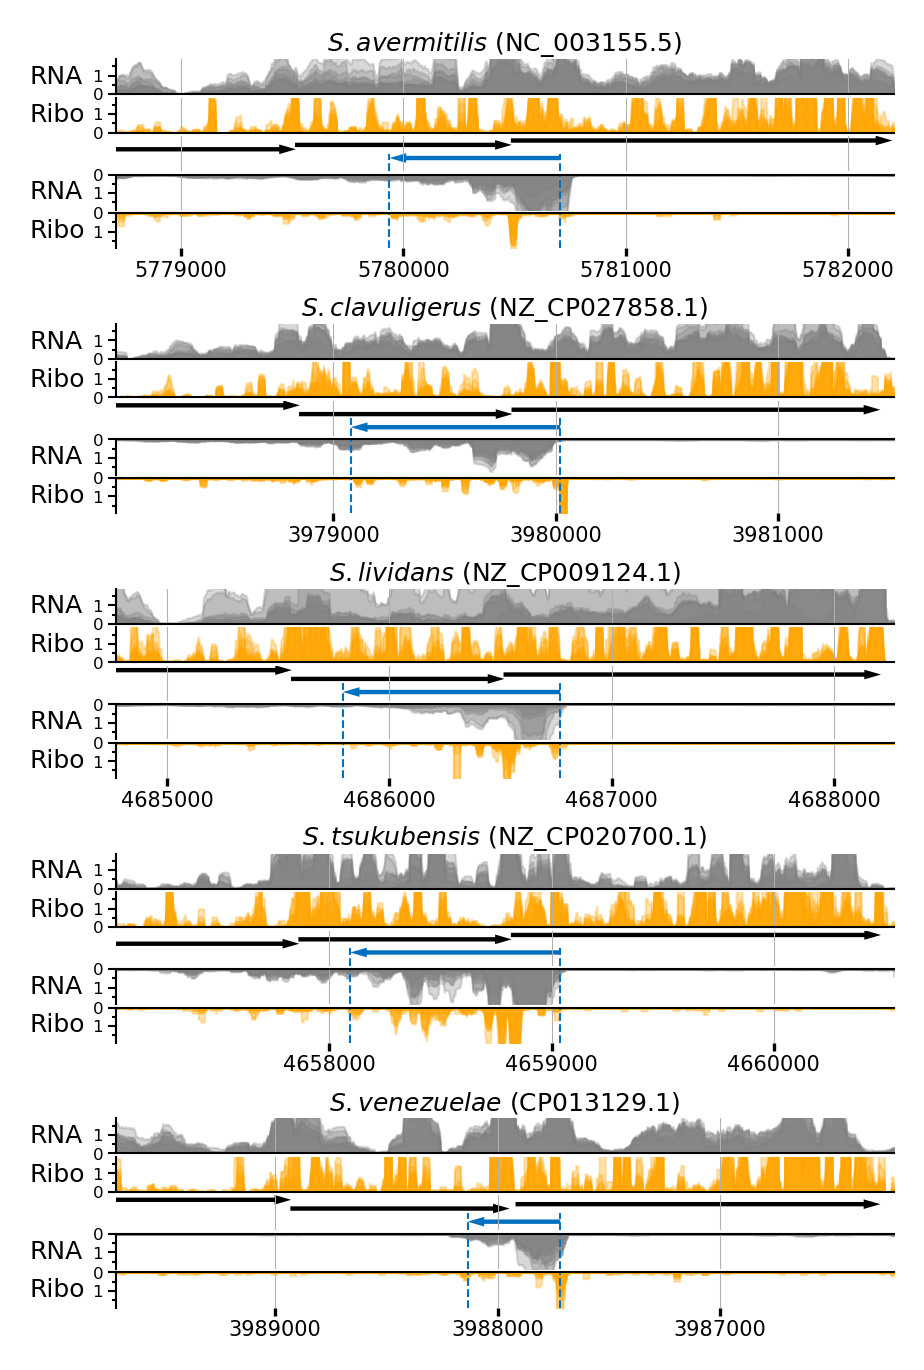

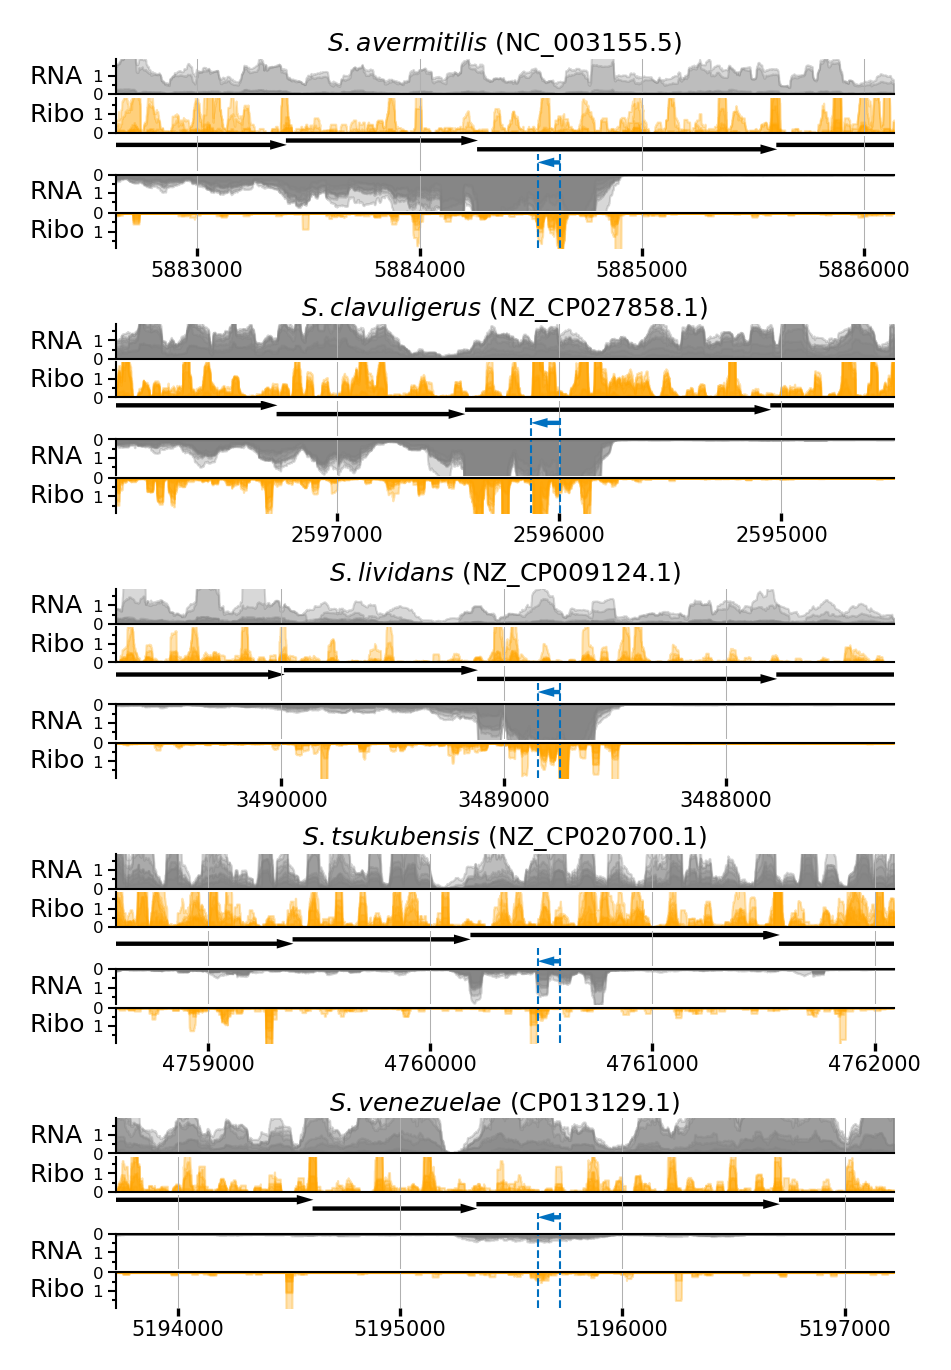

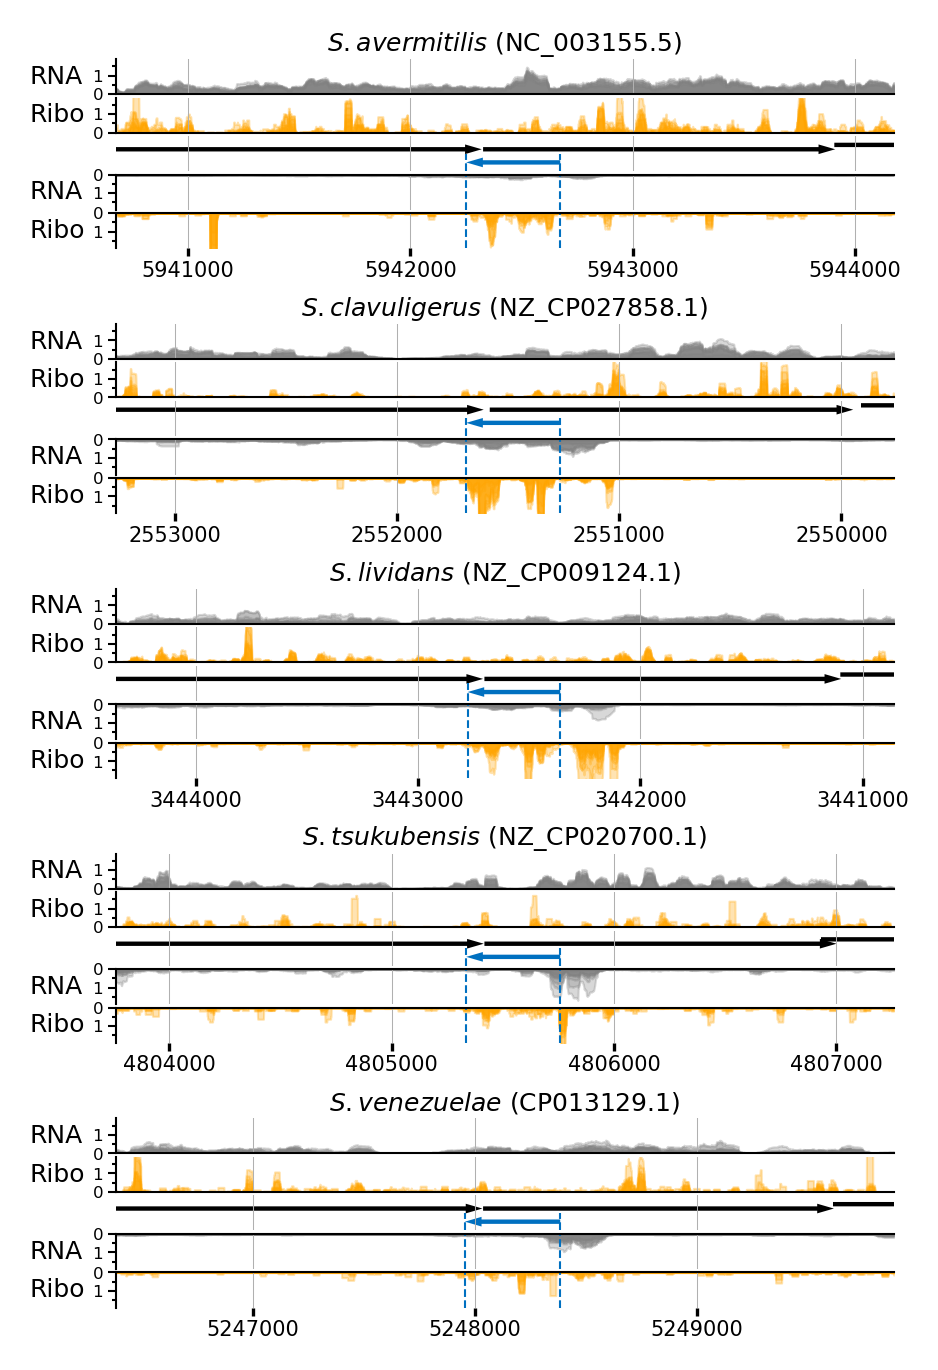

In [78]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.patches import FancyArrow
from matplotlib.collections import LineCollection, PatchCollection
mm = 1 / 25.4

grp = {}
for idx, _ in expression_signals.items():
    if not is_single[idx]: continue
    genelist = {}
    with plt.rc_context({
        'font.size': 6, 'axes.linewidth': 0.5, 
        'xtick.labelsize': 5, 'xtick.major.size': 2, #'xtick.minor.size': 1, 'xtick.major.width': 0.25, 'xtick.minor.width': 0.25, 
        'ytick.labelsize': 4, 'ytick.major.size': 2, 'ytick.minor.size': 1, 'ytick.major.width': 0.5, 'ytick.minor.width': 0.5, 'ytick.major.pad': 1
    }):
        fig = plt.figure(figsize=(85*mm, 140*mm), dpi=300)
        gs = GridSpec(5, 1, fig, hspace=0.4)
        #fig, axes = plt.subplots(5, figsize=(85*mm, 100*mm), dpi=300)
        for gs_i, (sp, name) in zip(gs, conservedOGs.loc[idx].items()):
            gs_sub = GridSpecFromSubplotSpec(5, 1, gs_i, hspace=0.1)
            ax = None
            ax1, ax2, ax3, ax4, ax5 = [ax:=fig.add_subplot(g, sharex=ax) for g in gs_sub]
            for ax in (ax1, ax2, ax3, ax4): 
                ax.xaxis.set_tick_params(bottom=False, labelbottom=False)
            ax3.yaxis.set_tick_params(left=False, labelleft=False)
            ax5.xaxis.set_tick_params(pad=1)
            ax5.xaxis.get_major_formatter().set_powerlimits((5,7))
            genelist[sp] = name
            print(sp, name)
            m = re.fullmatch(ptrn, name)
            start, end, strand = int(m.group('start')), int(m.group('end')), 1 if m.group('strand')=='+' else -1
            
            arrow_kw = dict(length_includes_head=True, head_length=75, head_width=2.2, width=1)
            if strand > 0:
                xlim_lb, xlim_ub = start-1500, start+2000
                for tag, rna in str5_plus_norm[(sp, 'RNA')].loc[xlim_lb:xlim_ub].items():
                    ax4.fill_between(rna.index, rna.tolist(), color='gray', alpha=0.3, lw=0.5)
                for tag, ribo in str5_plus_norm[(sp, 'Ribo')].loc[xlim_lb:xlim_ub].items():
                    ax5.fill_between(ribo.index, ribo.tolist(), color='orange', alpha=0.3, lw=0.5)
                
                for tag, rna in str5_minus_norm[(sp, 'RNA')].loc[xlim_lb:xlim_ub].items():
                    ax1.fill_between(rna.index, rna.tolist(), color='gray', alpha=0.3, lw=0.5)
                for tag, ribo in str5_minus_norm[(sp, 'Ribo')].loc[xlim_lb:xlim_ub].items():
                    ax2.fill_between(ribo.index, ribo.tolist(), color='orange', alpha=0.3, lw=0.5)
                
                ax3.add_collection(PatchCollection([
                    FancyArrow(s, 3-s%3, e-s, 0, **arrow_kw) if d.strand > 0 else FancyArrow(e, -1-s%3, s-e, 0, **arrow_kw)
                    for s, e, d in itvs[sp][xlim_lb:xlim_ub]
                ], ec='None', fc='k', lw=0.5))
                ax3.add_patch(
                    FancyArrow(start, 3-start%3, end-start, 0, ec='None', fc='#0070c0', **arrow_kw)
                )
                ax3.set_xlim(xlim_ub, xlim_lb)
                ax3.set_ylim(4, -4)
            else:
                xlim_lb, xlim_ub = end-2000, end+1500
                for tag, rna in str5_plus_norm[(sp, 'RNA')].loc[xlim_lb:xlim_ub].items():
                    ax1.fill_between(rna.index, rna.tolist(), color='gray', alpha=0.3, lw=0.5)
                for tag, ribo in str5_plus_norm[(sp, 'Ribo')].loc[xlim_lb:xlim_ub].items():
                    ax2.fill_between(ribo.index, ribo.tolist(), color='orange', alpha=0.3, lw=0.5)
                
                for tag, rna in str5_minus_norm[(sp, 'RNA')].loc[xlim_lb:xlim_ub].items():
                    ax4.fill_between(rna.index, rna.tolist(), color='gray', alpha=0.3, lw=0.5)
                for tag, ribo in str5_minus_norm[(sp, 'Ribo')].loc[xlim_lb:xlim_ub].items():
                    ax5.fill_between(ribo.index, ribo.tolist(), color='orange', alpha=0.3, lw=0.5)
                
                ax3.add_collection(PatchCollection([
                    FancyArrow(s, 3-s%3, e-s, 0, **arrow_kw) if d.strand > 0 else FancyArrow(e, -1-s%3, s-e, 0, **arrow_kw)
                    for s, e, d in itvs[sp][xlim_lb:xlim_ub]
                ], ec='None', fc='k', lw=0.5))
                
                ax3.add_patch(
                    FancyArrow(end, -1-start%3, start-end, 0, ec='None', fc='#0070c0', **arrow_kw)
                )
                ax3.set_xlim(xlim_lb, xlim_ub)
                ax3.set_ylim(-4, 4)
            
            ax1.set_ylim(0, 1.9)
            ax2.set_ylim(0, 1.9)
            ax4.set_ylim(1.9, 0)
            ax5.set_ylim(1.9, 0)
            
            ylabel_kw = dict(rotation=0, ha='left', va='center', labelpad=15)
            ax1.set_ylabel('RNA' , **ylabel_kw)
            ax2.set_ylabel('Ribo', **ylabel_kw)
            ax4.set_ylabel('RNA' , **ylabel_kw)
            ax5.set_ylabel('Ribo', **ylabel_kw)
            
            vline_kw = dict(lw=0.5, ls='--', c='#0070c0')
            ax3.axvline(start, ymax=0.5, **vline_kw)
            ax3.axvline(end  , ymax=0.5, **vline_kw)
            ax4.axvline(start, **vline_kw)
            ax4.axvline(end  , **vline_kw)
            ax5.axvline(start, **vline_kw)
            ax5.axvline(end  , **vline_kw)
            
            for ax in (ax1, ax2, ax3):
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
            for ax in (ax3, ax4, ax5):
                ax.spines['bottom'].set_visible(False)
                ax.spines['right'].set_visible(False)
            ax3.spines['left'].set_visible(False)
            
            for ax in (ax1, ax2, ax3, ax4, ax5):
                ax.xaxis.grid(True, lw=0.25)
                
            for ax in (ax1, ax2, ax4, ax5):
                ax.yaxis.set_major_locator(plt.MultipleLocator(1))
                ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
            ax1.set_title(f'$\it{nmap[sp]}$ ({m.group("recid")})', pad=2, fontsize=6)
            ax5.xaxis.set_major_locator(plt.MultipleLocator(1000))
        print()
        
        fig.savefig(f'./Figs/Fig1c-{len(grp)}.pdf', bbox_inches='tight')
        grp[len(grp)] = genelist
        

In [15]:
from Bio import SeqIO
arfs = {
    sp: 
    SeqIO.to_dict(SeqIO.parse(path2.data/'expression'/'Kim+20SciData'/'noncoding_og'/'input'/sp, 'fasta'))
    for sp in str5_refs['species_code']
}

In [21]:
for i, genelist in grp.items():
    for sp, name in genelist.items():
        print(f'>{name}')
        print(arfs[sp][name].seq)
    print()

>NC_003155.5[4997823:4998021](+)
MSSRSNGVMNEEFSWWKIACVASSPACSAARIRSAISARAEASAPSSSIRSFEPVTMLSADAANMS
>NZ_CP027858.1[3031639:3031837](+)
MSSRSNGVMNEEFNWWKMAWVASSPACSAARMRSAISARAEGSAPSSSIRSLEPVTMLSADAANMS
>NZ_CP009124.1[3935068:3935266](+)
MSSRSKGVMNEEFSWWKIACVASSPACSAARIRSAISARADASAPSSSIRSLEPVTMLSAEAANMS
>NZ_CP020700.1[3642202:3642400](+)
MSCRSNGVMNEELSWWKMAWVASSPACSAARIRSAISLRDDASAPSSSMRSLEPVTMLSAEAANMS
>CP013129.1[4789017:4789215](-)
MSSRSKGVMKEEFSWWKIAWVASSPACSAARIRSAISARAEGSAPSSSIRSLEPVTMLSADAANMS

>NC_003155.5[4997851:4997986](+)
TRSSAGGRSRAWHRHRRVPRPAYALRSRPGRRRPPRAVPSGASSP
>NZ_CP027858.1[3031667:3031802](+)
TRSSTGGRWHGWRRRPRAPPPACAPRSRHVRRVRPRAAPSGAWSP
>NZ_CP009124.1[3935096:3935231](+)
TRSSAGGRSRAWRRHPRVRRPAYALRSRPGRMRPPRAVPSGAWSP
>NZ_CP020700.1[3642242:3642347](+)
AGGRWHGWRRHPRVPRPASAPRSRSATTRRPRAVP
>CP013129.1[4789052:4789187](-)
RRSSAGGRSRGWRRRLRAPLPASAPRSRPGRKVPLRAVPSGAWSP

>NC_003155.5[5779938:5780706](-)
RRIRIRIRRRVQHGDALPGMRTDHVEHLMLGDKNVRSRQRLHGAQCEQSRISGTGTQEGDVPVFRTGGKG